# Определение возраста покупателей

## Исследовательский анализ данных

Описание проекта     
Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей.     
Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:        
    Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;     
    Контролировать добросовестность кассиров при продаже алкоголя.     
Постройте модель, которая по фотографии определит приблизительный возраст человека.     
В вашем распоряжении набор фотографий людей с указанием возраста. 

Изображения можно взять по ссылке https://chalearnlap.cvc.uab.es/dataset/26/description/

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
labels.shape

(7591, 2)

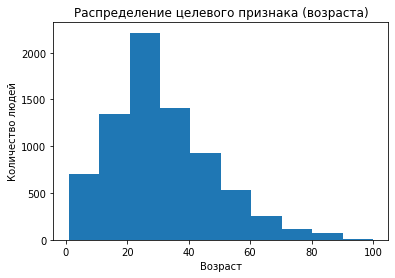

In [5]:
plt.hist(labels['real_age'])
plt.title('Распределение целевого признака (возраста)')
plt.xlabel('Возраст')
plt.ylabel('Количество людей')
plt.show()

Возраст распределен нормально

In [6]:
for i in range(10):
    image = Image.open('/datasets/faces/final_files/00000'+str(i)+'.jpg')
    array = np.array(image)
    print(array.shape)

(114, 114, 3)
(784, 784, 3)
(133, 133, 3)
(370, 370, 3)
(212, 212, 3)
(636, 637, 3)
(412, 412, 3)
(311, 311, 3)
(898, 897, 3)
(724, 724, 3)


In [7]:
datagen = ImageDataGenerator() 
datagen = ImageDataGenerator(rescale=1./255)
datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [8]:
features, target = next(datagen_flow)
print(features.shape)

(32, 224, 224, 3)


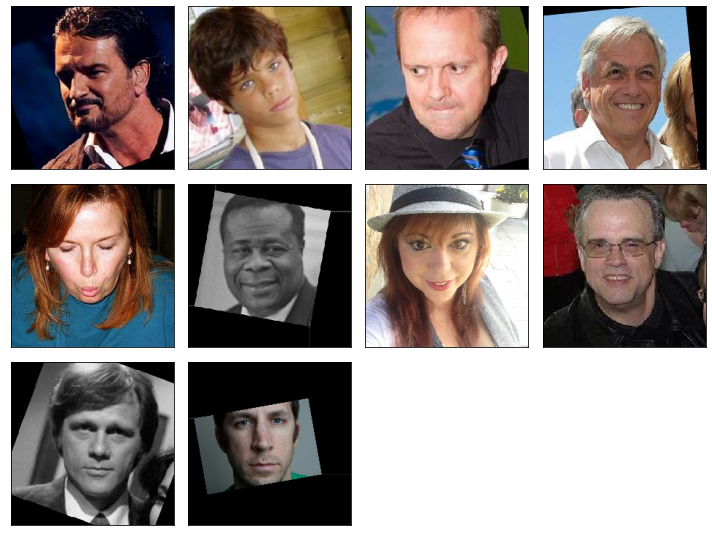

In [9]:
features, target = next(datagen_flow)
fig = plt.figure(figsize=(10,10))
for i in range(10):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Вывод по исследовательскому анализу данных:**   

Так как изображения имеют различный размер, приводим изображения к одинаковому размеру. Теперь признаки - четырёхмерный тензор, в котором 32 изображения размером 224 на 224 с тремя цветовыми каналами.  В нашем распоряжении 7591 изображений, далее разделим выборку на обучающую и тестовую и проведем обучение модели.    
Аугментация судя по всему уже сделана, так как некоторые изображения в датасете повернуты.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.preprocessing.image import ImageDataGenerator 
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50

labels = pd.read_csv('/datasets/faces/labels.csv')

datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)



def load_train(path):

    train_datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
    return train_datagen_flow
	
def load_test(path):
    val_datagen_flow  = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return  val_datagen_flow 
	
def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)
 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(64, input_dim=4, activation='relu')),
    model.add(Dense(32, activation='relu')),
    model.add(Dense(1))
    model.compile(loss='mean_squared_error',
                  optimizer=optimizer,
                  metrics=['mean_absolute_error'])
 
    return model
 
 
def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
    train_datagen = train_data
    model.fit(train_datagen,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
 
    return model

```

```

Train for 178 steps, validate for 60 steps
Epoch 1/10
2023-05-07 13:58:17.355531: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-05-07 13:58:18.031589: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 87s - loss: 241.4298 - mean_absolute_error: 11.0955 - val_loss: 624.1016 - val_mean_absolute_error: 19.9725
Epoch 2/10
178/178 - 66s - loss: 60.6425 - mean_absolute_error: 5.8690 - val_loss: 636.5662 - val_mean_absolute_error: 20.1067
Epoch 3/10
178/178 - 67s - loss: 28.1486 - mean_absolute_error: 4.0662 - val_loss: 328.9689 - val_mean_absolute_error: 13.3356
Epoch 4/10
178/178 - 67s - loss: 17.7642 - mean_absolute_error: 3.2205 - val_loss: 115.4638 - val_mean_absolute_error: 8.2833
Epoch 5/10
178/178 - 67s - loss: 12.6896 - mean_absolute_error: 2.7295 - val_loss: 79.8982 - val_mean_absolute_error: 6.7497
Epoch 6/10
178/178 - 67s - loss: 11.5261 - mean_absolute_error: 2.5654 - val_loss: 70.4176 - val_mean_absolute_error: 6.3329
Epoch 7/10
178/178 - 67s - loss: 9.5675 - mean_absolute_error: 2.3258 - val_loss: 68.4203 - val_mean_absolute_error: 6.2081
Epoch 8/10
178/178 - 67s - loss: 7.5713 - mean_absolute_error: 2.0736 - val_loss: 71.0514 - val_mean_absolute_error: 6.2845
Epoch 9/10
178/178 - 68s - loss: 6.8651 - mean_absolute_error: 1.9737 - val_loss: 65.5294 - val_mean_absolute_error: 6.1001
Epoch 10/10
178/178 - 66s - loss: 6.2027 - mean_absolute_error: 1.8532 - val_loss: 67.5397 - val_mean_absolute_error: 6.3023
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 12s - loss: 67.5397 - mean_absolute_error: 6.3023
Test MAE: 6.3023

```

## Анализ обученной модели

Вывод:  
Модель ResNet50 подошла для решения задачи регрессии - определения возраста человека по фотографии. Модель обучается достаточно быстро (менее 30 минут) и имеет высокую точность. Метрика MAE: 6.3023. 

## Чек-лист

- [x]  Jupyter Notebook открыт
- [X]  Весь код выполняется без ошибок
- [X]  Ячейки с кодом расположены в порядке исполнения
- [X]  Исследовательский анализ данных выполнен
- [X]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [X]  MAE модели не больше 8
- [X]  Код обучения модели скопирован в финальную тетрадь
- [X]  Результат вывода модели на экран перенесён в финальную тетрадь
- [X]  По итогам обучения модели сделаны выводы